In [2]:
import numpy as np

A = np.array([[90, 80, 40],
              [90, 60, 80],
              [60, 50, 70],
              [30, 40, 70],
              [30, 20, 90]])

ones = np.ones([5, 5])
deviation = A - (ones.dot(A) / len(A))
covariance = deviation.T.dot(deviation)
print(covariance)

[[ 3600.  2400. -1200.]
 [ 2400.  2000. -1400.]
 [-1200. -1400.  1400.]]


In [5]:
import numpy as np

# Initial Values
x = 50
x_dot = 5

# Standard Deviations
x_std = 0.5
x_dot_std = 0.2

# Variance
x_var = x_std ** 2
x_dot_var = x_dot_std ** 2

x_cov_x_dot = x_std * x_dot_std
x_dot_cov_x = x_dot_std * x_std

X = np.array([[x], [x_dot]])
P = np.array([[x_var, x_cov_x_dot],
              [x_dot_cov_x, x_dot_var]])

print(P)

[[0.25 0.1 ]
 [0.1  0.04]]


In [8]:
import numpy as np
from numpy.linalg import inv

x_observations = np.array([4000, 4260, 4550, 4860, 5110])
v_observations = np.array([2820, 2862, 2885, 2086, 2900])

z = np.c_[x_observations, v_observations]

# Initial Conditions
a = 2  # Acceleration
v = 280
t = 1  # Difference in time

# Process / Estimation Errors
error_est_x = 20
error_est_v = 5

# Observation Errors
error_obs_x = 25  # Uncertainty in the measurement
error_obs_v = 6

def prediction2d(x, v, t, a):
    A = np.array([[1, t],
                  [0, 1]])
    X = np.array([[x],
                  [v]])
    B = np.array([[0.5 * t ** 2],
                  [t]])
    X_prime = A.dot(X) + B.dot(a)
    return X_prime


def covariance2d(sigma1, sigma2):
    cov1_2 = sigma1 * sigma2
    cov2_1 = sigma2 * sigma1
    cov_matrix = np.array([[sigma1 ** 2, cov1_2],
                           [cov2_1, sigma2 ** 2]])
    return np.diag(np.diag(cov_matrix))


# Initial Estimation Covariance Matrix
P = covariance2d(error_est_x, error_est_v)
A = np.array([[1, t],
              [0, 1]])

# Initial State Matrix
X = np.array([[z[0][0]],
              [v]])
n = len(z[0])

for data in z[1:]:
    X = prediction2d(X[0][0], X[1][0], t, a)
    # To simplify the problem, professor
    # set off-diagonal terms to 0.
    P = np.diag(np.diag(A.dot(P).dot(A.T)))

    # Calculating the Kalman Gain
    H = np.identity(n)
    R = covariance2d(error_obs_x, error_obs_v)
    S = H.dot(P).dot(H.T) + R
    K = P.dot(H).dot(inv(S))

    # Reshape the new data into the measurement space.
    Y = H.dot(data).reshape(n, -1)

    # Update the State Matrix
    # Combination of the predicted state, measured values, covariance matrix and Kalman Gain
    X = X + K.dot(Y - H.dot(X))

    # Update Process Covariance Matrix
    P = (np.identity(len(K)) - K.dot(H)).dot(P)

print("Kalman Filter State Matrix:\n", X)

Kalman Filter State Matrix:
 [[7742.19549603]
 [2051.41911765]]


In [2]:
from scipy import linalg
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon import Kalman, LinearStateSpace
from scipy.stats import norm
from scipy.integrate import quad
from numpy.random import multivariate_normal
from scipy.linalg import eigvals


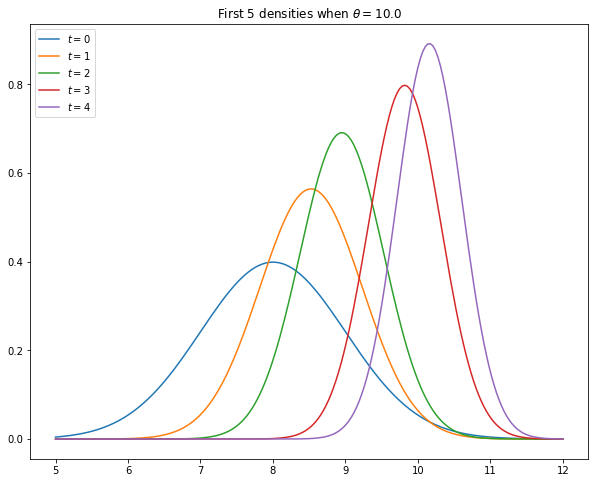

In [3]:
# Parameters
θ = 10  # Constant value of state x_t
A, C, G, H = 1, 0, 1, 1
ss = LinearStateSpace(A, C, G, H, mu_0=θ)

# Set prior, initialize kalman filter
x_hat_0, Σ_0 = 8, 1
kalman = Kalman(ss, x_hat_0, Σ_0)

# Draw observations of y from state space model
N = 5
x, y = ss.simulate(N)
y = y.flatten()

# Set up plot
fig, ax = plt.subplots(figsize=(10,8))
xgrid = np.linspace(θ - 5, θ + 2, 200)

for i in range(N):
    # Record the current predicted mean and variance
    m, v = [float(z) for z in (kalman.x_hat, kalman.Sigma)]
    # Plot, update filter
    ax.plot(xgrid, norm.pdf(xgrid, loc=m, scale=np.sqrt(v)), label=f'$t={i}$')
    kalman.update(y[i])

ax.set_title(f'First {N} densities when $\\theta = {θ:.1f}$')
ax.legend(loc='upper left')
plt.show()

Eigenvalues of A:
[ 0.9+0.j -0.1+0.j]
Stationary prediction error variance:
[[0.40329108 0.1050718 ]
 [0.1050718  0.41061709]]


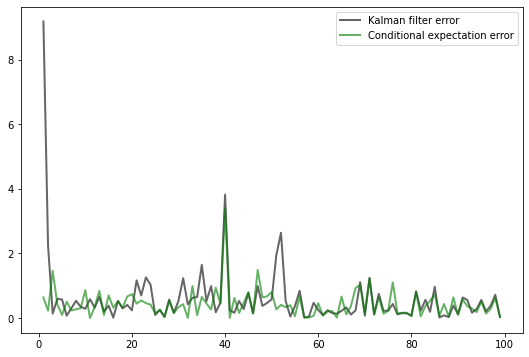

In [8]:
# Define A, C, G, H
G = np.identity(2)
H = np.sqrt(0.5) * np.identity(2)

A = [[0.5, 0.4],
     [0.6, 0.3],]
C = np.sqrt(0.3) * np.identity(2)

# Set up state space mode, initial value x_0 set to zero
ss = LinearStateSpace(A, C, G, H, mu_0 = np.zeros(2))

# Define the prior density
Σ = [[0.9, 0.3],
     [0.3, 0.9]]
Σ = np.array(Σ)
x_hat = np.array([8, 8])

# Initialize the Kalman filter
kn = Kalman(ss, x_hat, Σ)

# Print eigenvalues of A
print("Eigenvalues of A:")
print(eigvals(A))

# Print stationary Σ
S, K = kn.stationary_values()
print("Stationary prediction error variance:")
print(S)

# Generate the plot
T = 100
x, y = ss.simulate(T)

e1 = np.empty(T-1)
e2 = np.empty(T-1)

for t in range(1, T):
    kn.update(y[:,t])
    e1[t-1] = np.sum((x[:, t] - kn.x_hat.flatten())**2)
    e2[t-1] = np.sum((x[:, t] - A @ x[:, t-1])**2)

fig, ax = plt.subplots(figsize=(9,6))
ax.plot(range(1, T), e1, 'k-', lw=2, alpha=0.6,
        label='Kalman filter error')
ax.plot(range(1, T), e2, 'g-', lw=2, alpha=0.6,
        label='Conditional expectation error')
ax.legend()
plt.show()

In [12]:
import numpy as np
np.set_printoptions(threshold=3)
np.set_printoptions(suppress=True)
from numpy import genfromtxt


#Notation used coming from: https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/


def prediction(X_hat_t_1,P_t_1,F_t,B_t,U_t,Q_t):
    X_hat_t=F_t.dot(X_hat_t_1)+(B_t.dot(U_t).reshape(B_t.shape[0],-1) )
    P_t=np.diag(np.diag(F_t.dot(P_t_1).dot(F_t.transpose())))+Q_t
    return X_hat_t,P_t
    

def update(X_hat_t,P_t,Z_t,R_t,H_t):
    
    K_prime=P_t.dot(H_t.transpose()).dot( np.linalg.inv ( H_t.dot(P_t).dot(H_t.transpose()) +R_t ) )  
    print("K:\n",K_prime)
    
    X_t=X_hat_t+K_prime.dot(Z_t-H_t.dot(X_hat_t))
    P_t=P_t-K_prime.dot(H_t).dot(P_t)
    
    return X_t,P_t


acceleration=0
delta_t=1/20#milisecond

groundTruth = genfromtxt('groundTruth.csv', delimiter=',',skip_header=1)

#Observations: position_X, position_Y
measurmens = genfromtxt('measurmens.csv', delimiter=',',skip_header=1)


#Checking our result with OpenCV
opencvKalmanOutput = genfromtxt('kalmanv.csv', delimiter=',',skip_header=1)

#Transition matrix
F_t=np.array([ [1 ,0,delta_t,0] , [0,1,0,delta_t] , [0,0,1,0] , [0,0,0,1] ])

#Initial State cov
P_t= np.identity(4)*0.2

#Process cov
Q_t= np.identity(4)

#Control matrix
B_t=np.array( [ [0] , [0], [0] , [0] ])

#Control vector
U_t=acceleration

#Measurment Matrix
H_t = np.array([ [1, 0, 0, 0], [ 0, 1, 0, 0]])

#Measurment cov
R_t= np.identity(2)*5

# Initial State
X_hat_t = np.array( [[0],[0],[0],[0]] )
print("X_hat_t",X_hat_t.shape)
print("P_t",P_t.shape)
print("F_t",F_t.shape)
print("B_t",B_t.shape)
print("Q_t",Q_t.shape)
print("R_t",R_t.shape)
print("H_t",H_t.shape)

for i in range(measurmens.shape[0]):
    X_hat_t,P_hat_t = prediction(X_hat_t,P_t,F_t,B_t,U_t,Q_t)
    print("Prediction:")
    print("X_hat_t:\n",X_hat_t,"\nP_t:\n",P_t)
    
    Z_t=measurmens[i].transpose()
    Z_t=Z_t.reshape(Z_t.shape[0],-1)
    
    print(Z_t.shape)
    
    X_t,P_t=update(X_hat_t,P_hat_t,Z_t,R_t,H_t)
    print("Update:")
    print("X_t:\n",X_t,"\nP_t:\n",P_t)
    X_hat_t=X_t
    P_hat_t=P_t
    
    print("=========================================")
    print("Opencv Kalman Output:")
    print("X_t:\n",opencvKalmanOutput[i])

X_hat_t (4, 1)
P_t (4, 4)
F_t (4, 4)
B_t (4, 1)
Q_t (4, 4)
R_t (2, 2)
H_t (2, 4)
Prediction:
X_hat_t:
 [[0.]
 [0.]
 [0.]
 [0.]] 
P_t:
 [[0.2 0.  0.  0. ]
 [0.  0.2 0.  0. ]
 [0.  0.  0.2 0. ]
 [0.  0.  0.  0.2]]
(2, 1)
K:
 [[0.19361342 0.        ]
 [0.         0.19361342]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[65.05410854]
 [95.06418837]
 [ 0.        ]
 [ 0.        ]] 
P_t:
 [[0.96806709 0.         0.         0.        ]
 [0.         0.96806709 0.         0.        ]
 [0.         0.         1.2        0.        ]
 [0.         0.         0.         1.2       ]]
Opencv Kalman Output:
X_t:
 [65. 95.]
Prediction:
X_hat_t:
 [[65.05410854]
 [95.06418837]
 [ 0.        ]
 [ 0.        ]] 
P_t:
 [[0.96806709 0.         0.         0.        ]
 [0.         0.96806709 0.         0.        ]
 [0.         0.         1.2        0.        ]
 [0.         0.         0.         1.2       ]]
(2, 1)
K:
 [[0.28274969 0.        ]
 [0.         0.28274969]
 [0.         0.        ]
 [

K:
 [[0.38486542 0.        ]
 [0.         0.38486542]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[370.92460393]
 [268.97724407]
 [  0.        ]
 [  0.        ]] 
P_t:
 [[ 1.92432709  0.          0.          0.        ]
 [ 0.          1.92432709  0.          0.        ]
 [ 0.          0.         83.2         0.        ]
 [ 0.          0.          0.         83.2       ]]
Opencv Kalman Output:
X_t:
 [378. 272.]
Prediction:
X_hat_t:
 [[370.92460393]
 [268.97724407]
 [  0.        ]
 [  0.        ]] 
P_t:
 [[ 1.92432709  0.          0.          0.        ]
 [ 0.          1.92432709  0.          0.        ]
 [ 0.          0.         83.2         0.        ]
 [ 0.          0.          0.         83.2       ]]
(2, 1)
K:
 [[0.38516984 0.        ]
 [0.         0.38516984]
 [0.         0.        ]
 [0.         0.        ]]
Update:
X_t:
 [[374.80534258]
 [273.99321684]
 [  0.        ]
 [  0.        ]] 
P_t:
 [[ 1.92584918  0.          0.          0.        ]
 [ 0.          1

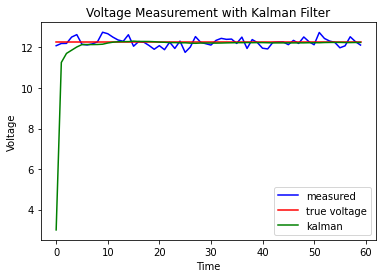

In [15]:
# kalman2.py
# written by Greg Czerniak (email is greg {aT] czerniak [dOt} info )
#
# Implements a multi-variable linear Kalman filter.
#
# Note: This code is part of a larger tutorial "Kalman Filters for Undergrads"
# located at http://greg.czerniak.info/node/5.

import pylab
import math
import random
import numpy

# Implements a linear Kalman filter.
class KalmanFilterLinear:
  def __init__(self,_A, _B, _H, _x, _P, _Q, _R):
    self.A = _A                      # State transition matrix.
    self.B = _B                      # Control matrix.
    self.H = _H                      # Observation matrix.
    self.current_state_estimate = _x # Initial state estimate.
    self.current_prob_estimate = _P  # Initial covariance estimate.
    self.Q = _Q                      # Estimated error in process.
    self.R = _R                      # Estimated error in measurements.
  def GetCurrentState(self):
    return self.current_state_estimate
  def Step(self,control_vector,measurement_vector):
    #---------------------------Prediction step-----------------------------
    predicted_state_estimate = self.A * self.current_state_estimate + self.B * control_vector
    predicted_prob_estimate = (self.A * self.current_prob_estimate) * numpy.transpose(self.A) + self.Q
    #--------------------------Observation step-----------------------------
    innovation = measurement_vector - self.H*predicted_state_estimate
    innovation_covariance = self.H*predicted_prob_estimate*numpy.transpose(self.H) + self.R
    #-----------------------------Update step-------------------------------
    kalman_gain = predicted_prob_estimate * numpy.transpose(self.H) * numpy.linalg.inv(innovation_covariance)
    self.current_state_estimate = predicted_state_estimate + kalman_gain * innovation
    # We need the size of the matrix so we can make an identity matrix.
    size = self.current_prob_estimate.shape[0]
    # eye(n) = nxn identity matrix.
    self.current_prob_estimate = (numpy.eye(size)-kalman_gain*self.H)*predicted_prob_estimate

# Simulates the classic physics problem of a cannon shooting a ball in a
# parabolic arc.  In addition to giving "true" values back, you can also ask
# for noisy values back to test Kalman filters.
class Cannon:
  #--------------------------------VARIABLES----------------------------------
  angle = 45 # The angle from the ground to point the cannon.
  muzzle_velocity = 100 # Muzzle velocity of the cannon.
  gravity = [0,-9.81] # A vector containing gravitational acceleration.
  # The initial velocity of the cannonball
  velocity = [muzzle_velocity*math.cos(angle*math.pi/180), muzzle_velocity*math.sin(angle*math.pi/180)]
  loc = [0,0] # The initial location of the cannonball.
  acceleration = [0,0] # The initial acceleration of the cannonball.
  #---------------------------------METHODS-----------------------------------
  def __init__(self,_timeslice,_noiselevel):
    self.timeslice = _timeslice
    self.noiselevel = _noiselevel
  def add(self,x,y):
    return x + y
  def mult(self,x,y):
    return x * y
  def GetX(self):
    return self.loc[0]
  def GetY(self):
    return self.loc[1]
  def GetXWithNoise(self):
    return random.gauss(self.GetX(),self.noiselevel)
  def GetYWithNoise(self):
    return random.gauss(self.GetY(),self.noiselevel)
  def GetXVelocity(self):
    return self.velocity[0]
  def GetYVelocity(self):
    return self.velocity[1]
  # Increment through the next timeslice of the simulation.
  def Step(self):
    # We're gonna use this vector to timeslice everything.
    timeslicevec = [self.timeslice,self.timeslice]
    # Break gravitational force into a smaller time slice.
    sliced_gravity = map(self.mult,self.gravity,timeslicevec)
    # The only force on the cannonball is gravity.
    sliced_acceleration = sliced_gravity
    # Apply the acceleration to velocity.
    self.velocity = map(self.add, self.velocity, sliced_acceleration)
    sliced_velocity = map(self.mult, self.velocity, timeslicevec )
    # Apply the velocity to location.
    self.loc = map(self.add, self.loc, sliced_velocity)
    # Cannonballs shouldn't go into the ground.
    if self.loc[1] < 0:
      self.loc[1] = 0

#=============================REAL PROGRAM START================================
# Let's go over the physics behind the cannon shot, just to make sure it's
# correct:
# sin(45)*100 = 70.710 and cos(45)*100 = 70.710
# vf = vo + at
# 0 = 70.710 + (-9.81)t
# t = 70.710/9.81 = 7.208 seconds for half
# 14.416 seconds for full journey
# distance = 70.710 m/s * 14.416 sec = 1019.36796 m

timeslice = 0.1 # How many seconds should elapse per iteration?
iterations = 144 # How many iterations should the simulation run for?
# (notice that the full journey takes 14.416 seconds, so 145 iterations will
# cover the whole thing when timeslice = 0.10)
noiselevel = 30  # How much noise should we add to the noisy measurements?
muzzle_velocity = 100 # How fast should the cannonball come out?
angle = 45 # Angle from the ground.

# These are arrays to store the data points we want to plot at the end.
x = []
y = []
nx = []
ny = []
kx = []
ky = []

# Let's make a cannon simulation.
c = Cannon(timeslice,noiselevel)

speedX = muzzle_velocity*math.cos(angle*math.pi/180)
speedY = muzzle_velocity*math.sin(angle*math.pi/180)

# This is the state transition vector, which represents part of the kinematics.
# 1, ts, 0,  0  =>  x(n+1) = x(n) + vx(n)
# 0,  1, 0,  0  => vx(n+1) =        vx(n)
# 0,  0, 1, ts  =>  y(n+1) =              y(n) + vy(n)
# 0,  0, 0,  1  => vy(n+1) =                     vy(n)
# Remember, acceleration gets added to these at the control vector.
state_transition = numpy.matrix([[1,timeslice,0,0],[0,1,0,0],[0,0,1,timeslice],[0,0,0,1]])

control_matrix = numpy.matrix([[0,0,0,0],[0,0,0,0],[0,0,1,0],[0,0,0,1]])
# The control vector, which adds acceleration to the kinematic equations.
# 0          =>  x(n+1) =  x(n+1)
# 0          => vx(n+1) = vx(n+1)
# -9.81*ts^2 =>  y(n+1) =  y(n+1) + 0.5*-9.81*ts^2
# -9.81*ts   => vy(n+1) = vy(n+1) + -9.81*ts
control_vector = numpy.matrix([[0],[0],[0.5*-9.81*timeslice*timeslice],[-9.81*timeslice]])

# After state transition and control, here are the equations:
#  x(n+1) = x(n) + vx(n)
# vx(n+1) = vx(n)
#  y(n+1) = y(n) + vy(n) - 0.5*9.81*ts^2
# vy(n+1) = vy(n) + -9.81*ts
# Which, if you recall, are the equations of motion for a parabola.  Perfect.

# Observation matrix is the identity matrix, since we can get direct
# measurements of all values in our example.
observation_matrix = numpy.eye(4)

# This is our guess of the initial state.  I intentionally set the Y value
# wrong to illustrate how fast the Kalman filter will pick up on that.
initial_state = numpy.matrix([[0],[speedX],[500],[speedY]])

initial_probability = numpy.eye(4)

process_covariance = numpy.zeros(4)
measurement_covariance = numpy.eye(4)*0.2

kf = KalmanFilterLinear(state_transition, control_matrix, observation_matrix, initial_state, initial_probability, process_covariance, measurement_covariance)

# Iterate through the simulation.
for i in range(iterations):
    x.append(c.GetX())
    y.append(c.GetY())
    newestX = c.GetXWithNoise()
    newestY = c.GetYWithNoise()
    nx.append(newestX)
    ny.append(newestY)
    # Iterate the cannon simulation to the next timeslice.
    c.Step()
    kx.append(kf.GetCurrentState()[0,0])
    ky.append(kf.GetCurrentState()[2,0])
    kf.Step(control_vector,numpy.matrix([[newestX],[c.GetXVelocity()],[newestY],[c.GetYVelocity()]]))

# Plot all the results we got.
pylab.plot(x,y,'-',nx,ny,':',kx,ky,'--')
pylab.xlabel('X position')
pylab.ylabel('Y position')
pylab.title('Measurement of a Cannonball in Flight')
pylab.legend(('true','measured','kalman'))
pylab.show()

In [5]:
from pykalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd

df = pd.read_csv('14122020.csv')
# df = pd.read_csv('dummy.csv')
value = df['us']
outlier_thresh = 0.95

# Treat y as position, and that y-dot is
# an unobserved state - the velocity,
# which is modelled as changing slowly (inertia)

# state vector [y,
#               y_dot]

# transition_matrix =  [[1, dt],
#                       [0, 1]]

observation_matrix = np.asarray([[1, 0]])

# observations:
# t = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
t = df['num']
# print(t)
# print(value)


# dt betweeen observations:
dt = [np.mean(np.diff(t))] + list(np.diff(t))
transition_matrices = np.asarray([[[1, each_dt],[0, 1]]
                                    for each_dt in dt])

# observations
# y = np.transpose(np.asarray([[-123.98,-121.61,-115.2,-120.53,-126.91,-120.72,-117.19,-136.22,-130.3,-123.82,-116.11,-115.11,-120.42,-125.57,-117.95,-129.23,-114.98,-121.22,-123.25,-129.54]]))
y = np.transpose(value)

y = np.ma.array(y)


leave_1_out_cov = []

for i in range(len(y)):
    y_masked = np.ma.array(copy.deepcopy(y))
    y_masked[i] = np.ma.masked

    kf1 = KalmanFilter(transition_matrices = transition_matrices,
                   observation_matrices = observation_matrix)

    kf1 = kf1.em(y_masked)

    leave_1_out_cov.append(kf1.observation_covariance[0,0])

# Find indexes that contributed excessively to observation covariance
outliers = (leave_1_out_cov / np.mean(leave_1_out_cov)) < outlier_thresh

for i in range(len(outliers)):
    if outliers[i]:
        y[i] = np.ma.masked


kf1 = KalmanFilter(transition_matrices = transition_matrices,
                   observation_matrices = observation_matrix)

kf1 = kf1.em(y)

(smoothed_state_means, smoothed_state_covariances) = kf1.smooth(y)


plt.figure()
plt.plot(t, y, 'go-', label="Observations")
plt.plot(t, smoothed_state_means[:,0], 'b--', label="Value Estimate" )
plt.legend(loc="upper left")
plt.xlabel("Time (s)")
plt.ylabel("Value (uS)")

plt.show()

KeyboardInterrupt: 